In [ ]:
import torch
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

from models.convnext import ConvRecon
from dataset import get_loader, load_image_pair_diffuser, load_image_pair_rml
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
from utils import MSE_Perceptual_Loss

/home/lakabuli/miniconda3/envs/convnext/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lakabuli/miniconda3/envs/convnext/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
gpu_number = 0
recon_dir = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/'

# Evaluation function for computing metrics on validation set

In [ ]:
# Evaluation function for computing metrics on validation set
def validate(model, val_loader, criterion, device, val_psnr, val_ssim, lpips, imager='diffuser', crop=False):
    """Evaluate model on validation set and compute metrics."""
    model.eval()
    print("Starting validation...")
    with torch.no_grad():
        total_loss = 0.0
        total_mse = 0
        total_lpips = 0.0

        for step, batch in enumerate(tqdm(val_loader)):
            input, target, _ = batch
            input, target = input.to(device), target.to(device)
            output = model(input)
            
            # crop if specified
            if crop:
                if imager == 'diffuser':
                    output = output[:, :, :131, 57:188]
                    target = target[:, :, :131, 57:188]
                elif imager == 'rml':
                    output = output[:, :, 16:132, 62:178]
                    target = target[:, :, 16:132, 62:178]
            
            loss = criterion(output.squeeze(), target)
            total_loss += loss
            val_psnr.update(output, target)
            val_ssim.update(output, target)
            total_mse += torch.nn.functional.mse_loss(output, target, reduction="mean").item()

            # LPIPS normalization
            output_min = torch.min(output)
            normalized_out = (output - output_min) / (torch.max(output) - output_min)
            total_lpips += lpips(normalized_out, target).item()

        avg_loss = total_loss / len(val_loader.dataset)
        avg_mse = total_mse / len(val_loader.dataset)
        avg_lpips = total_lpips / len(val_loader.dataset)
        avg_psnr = val_psnr.compute()
        avg_ssim = val_ssim.compute()
        val_psnr.reset()
        val_ssim.reset()
        
        print(f'Val Loss: {avg_loss}, Val PSNR: {avg_psnr}, Val SSIM: {avg_ssim}, Val MSE: {avg_mse}, Val LPIPS: {avg_lpips}\n')
        return avg_psnr, avg_loss, avg_ssim, avg_lpips

# DiffuserCam Model Evaluation

In [ ]:
# Configuration
save_path = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/experiments_diffusercam/'
dataset = "ClaraMirflickr"
imager = 'diffuser'
is_rml = False
model_type = 'convnext'
height = 150
width = 240
n_channels = 3
num_workers = 1

# Setup device
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.set_device(gpu_number)
else:
    device = torch.device('cpu')

# Load model
if model_type == 'convnext':
    model = ConvRecon(n_channels, height, width)
else:
    raise TypeError(f"{model_type} is not a valid model type.")

saved_model = save_path + 'best_model.pth'
if torch.cuda.is_available():
    model.load_state_dict(torch.load(saved_model))
else:
    model.load_state_dict(torch.load(saved_model, map_location=torch.device('cpu')))
model = model.to(device)

# Load data
_, val_loader = get_loader(dataset, batch_size=8, num_workers=num_workers, is_rml=is_rml)

object index 64, PSNR: 23.63729476928711, SSIM: 0.7456709742546082, LPIPS: 0.10903812944889069, MSE: 0.004327831324189901
object index 67, PSNR: 28.195600509643555, SSIM: 0.8617866039276123, LPIPS: 0.07189987599849701, MSE: 0.0015150952385738492
object index 89, PSNR: 28.66279411315918, SSIM: 0.8026558756828308, LPIPS: 0.13012638688087463, MSE: 0.0013605686835944653
object index 1, PSNR: 27.812641143798828, SSIM: 0.7840733528137207, LPIPS: 0.10215841233730316, MSE: 0.0016547631239518523
object index 2, PSNR: 24.43976593017578, SSIM: 0.7176498174667358, LPIPS: 0.10986101627349854, MSE: 0.003597686532884836


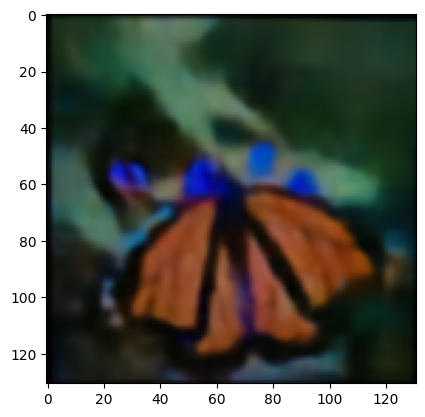

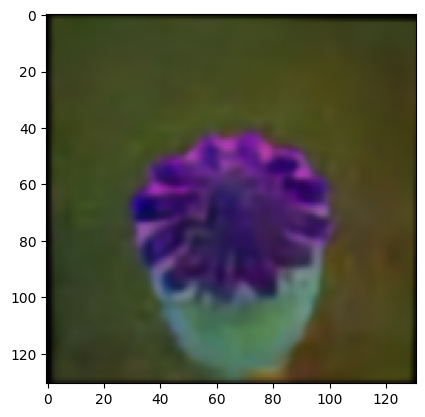

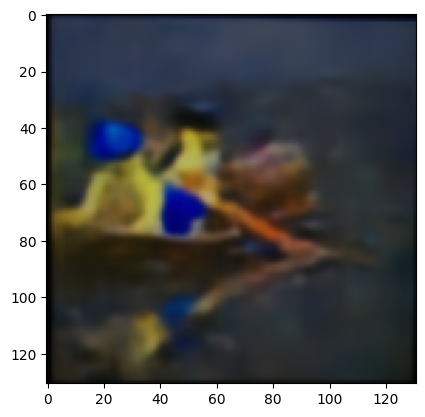

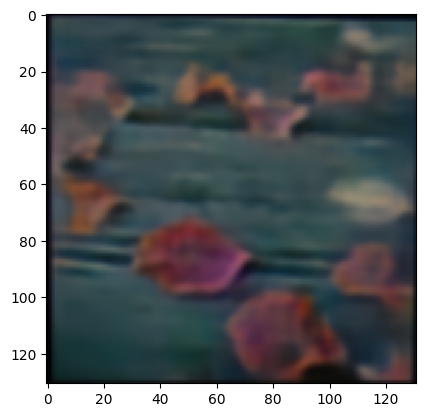

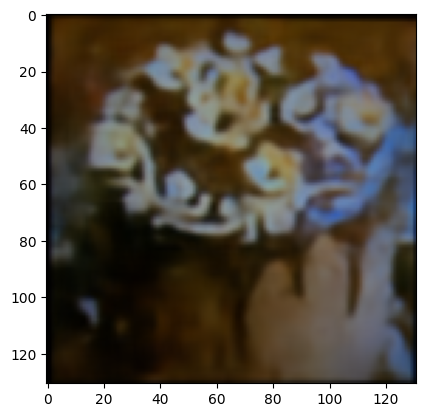

In [ ]:
# Evaluate on selected images
object_indices = [64, 67, 89, 1, 2] # butterfly, flower, lego dudes, blue flowers, cake
uncropped_inference_images = []
cropped_inference_images = []
psnrs = []
ssims = []
lpipss = []
mses = []

psnr_metric = PSNR(data_range=1.0).to(device)
ssim_metric = SSIM(data_range=1.0).to(device)
lpips_metric = LPIPS(net_type='alex').to(device)

for image_idx in object_indices:
    if imager == 'diffuser':
        measurement, gt = load_image_pair_diffuser(img_number=image_idx)
    elif imager == 'rml':
        measurement, gt = load_image_pair_rml(img_number=image_idx)
    
    gt = torch.from_numpy(gt)
    gt = torch.moveaxis(gt, -1, 0)
    gt = gt.unsqueeze(0)
    
    with torch.no_grad():
        model.eval()
        inputs = measurement.to(device)
        label = gt.to(device)
        output = model(inputs)
        output = torch.clamp(output, 0, 1)
        
        uncropped_inference_images.append(output.squeeze().cpu().detach().numpy())
        
        # Crop for DiffuserCam
        output_cropped = output[:, :, :131, 57:188]
        label_cropped = label[:, :, :131, 57:188]
        cropped_inference_images.append(output_cropped.squeeze().cpu().detach().numpy())
        
        psnr_val = psnr_metric(output_cropped, label_cropped)
        ssim_val = ssim_metric(output_cropped, label_cropped)
        lpips_val = lpips_metric(output_cropped, label_cropped)
        mse_val = torch.nn.functional.mse_loss(output_cropped, label_cropped)
        
        print(f'Image {image_idx}, PSNR: {psnr_val.item():.4f}, SSIM: {ssim_val.item():.4f}, LPIPS: {lpips_val.item():.4f}, MSE: {mse_val.item():.6f}')
        psnrs.append(psnr_val.item())
        ssims.append(ssim_val.item())
        lpipss.append(lpips_val.item())
        mses.append(mse_val.item())

np.save(recon_dir + f'uncropped_inference_images_{imager}.npy', np.array(uncropped_inference_images))
np.save(recon_dir + f'cropped_inference_images_{imager}.npy', np.array(cropped_inference_images))
np.save(recon_dir + f'metrics_{imager}.npy', np.array([psnrs, ssims, lpipss, mses]))


## Evaluate on full test set (uncropped)

In [ ]:
lpips = LPIPS(net_type='alex', normalize=True).to(device)
val_psnr = PSNR(data_range=1.0).to(device)
val_ssim = SSIM(data_range=1.0).to(device)
criterion = MSE_Perceptual_Loss(device, alpha=0, is_lpips=True)

with torch.no_grad():
    val_psnr_out, val_mse_loss, val_ssim_out, val_lpips_out = validate(
        model, val_loader, criterion, device, val_psnr, val_ssim, lpips, imager=imager, crop=False
    )
print(f'Uncropped - PSNR: {val_psnr_out:.4f}, MSE: {val_mse_loss:.6f}, SSIM: {val_ssim_out:.4f}, LPIPS: {val_lpips_out:.6f}')
np.save(recon_dir + f'test_set_metrics_uncropped_{imager}.npy', 
        np.array([val_psnr_out.cpu(), val_mse_loss.cpu(), val_ssim_out.cpu(), val_lpips_out]))

Starting validation...


100%|██████████| 125/125 [30:24<00:00, 14.60s/it]

Val Loss: 8.321525092469528e-05, Val PSNR: 31.767074584960938, Val SSIM: 0.9125829339027405, Val MSE: 8.321518608136102e-05, Val LPIPS: 0.016005759477615355 

Val PSNR: 31.767074584960938, Val MSE Loss: 8.321525092469528e-05, Val SSIM: 0.9125829339027405, Val LPIPS: 0.016005759477615355 



## Evaluate on full test set (cropped - final reported metrics)

In [ ]:
lpips = LPIPS(net_type='alex', normalize=True).to(device)
val_psnr = PSNR(data_range=1.0).to(device)
val_ssim = SSIM(data_range=1.0).to(device)
criterion = MSE_Perceptual_Loss(device, alpha=0, is_lpips=True)

with torch.no_grad():
    val_psnr_out, val_mse_loss, val_ssim_out, val_lpips_out = validate(
        model, val_loader, criterion, device, val_psnr, val_ssim, lpips, imager=imager, crop=True
    )
print(f'Cropped - PSNR: {val_psnr_out:.4f}, MSE: {val_mse_loss:.6f}, SSIM: {val_ssim_out:.4f}, LPIPS: {val_lpips_out:.6f}')
np.save(recon_dir + f'test_set_metrics_cropped_{imager}.npy', 
        np.array([val_psnr_out.cpu(), val_mse_loss.cpu(), val_ssim_out.cpu(), val_lpips_out]))

Val PSNR: 31.767074584960938, Val MSE Loss: 8.321525092469528e-05, Val SSIM: 0.9125829339027405, Val LPIPS: 0.016005759477615355 



# RML Model Evaluation

In [ ]:
# Configuration
save_path = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/experiments_rml/'
dataset = "ClaraMirflickr"
imager = 'rml'
is_rml = True
model_type = 'convnext'
height = 150
width = 240
n_channels = 3
num_workers = 1

# Setup device
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.set_device(gpu_number)
else:
    device = torch.device('cpu')

# Load model
if model_type == 'convnext':
    model = ConvRecon(n_channels, height, width)
else:
    raise TypeError(f"{model_type} is not a valid model type.")

saved_model = save_path + 'best_model.pth'
if torch.cuda.is_available():
    model.load_state_dict(torch.load(saved_model))
else:
    model.load_state_dict(torch.load(saved_model, map_location=torch.device('cpu')))
model = model.to(device)

# Load data
_, val_loader = get_loader(dataset, batch_size=8, num_workers=num_workers, is_rml=is_rml)


object index 64, PSNR: 27.031986236572266, SSIM: 0.8635454773902893, LPIPS: 0.0402812585234642, MSE: 0.001980620203539729
object index 67, PSNR: 29.87554931640625, SSIM: 0.8981035351753235, LPIPS: 0.028122592717409134, MSE: 0.0010290698846802115
object index 89, PSNR: 30.673423767089844, SSIM: 0.8616989254951477, LPIPS: 0.05047637224197388, MSE: 0.0008563622832298279
object index 1, PSNR: 27.442739486694336, SSIM: 0.7437152862548828, LPIPS: 0.05721532180905342, MSE: 0.001801880425773561
object index 2, PSNR: 24.816640853881836, SSIM: 0.7557084560394287, LPIPS: 0.05222422629594803, MSE: 0.0032986472360789776


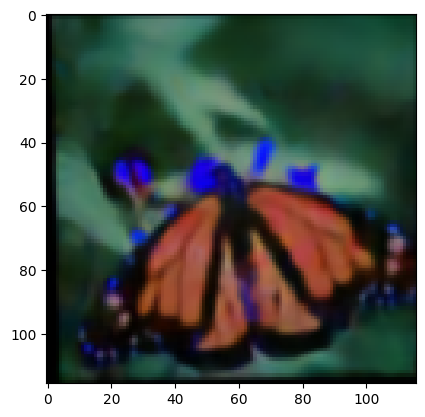

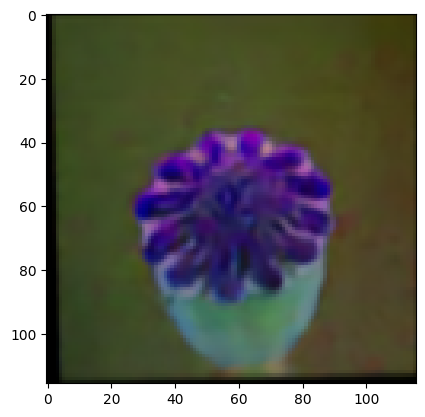

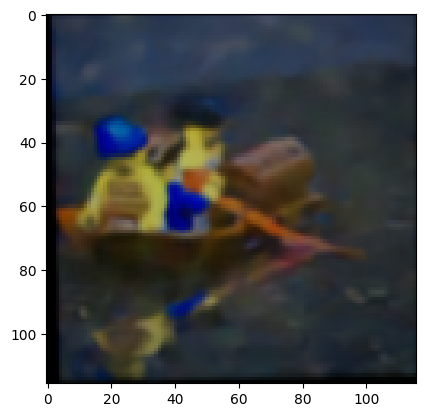

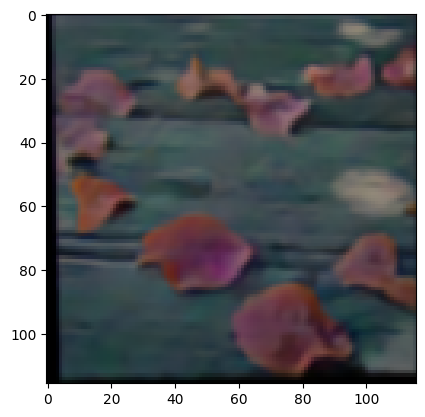

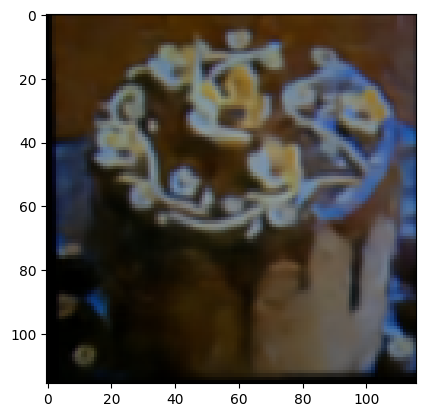

In [ ]:
object_indices = [64, 67, 89, 1, 2]
uncropped_inference_images = []
cropped_inference_images = []
psnrs = []
ssims = []
lpipss = []
mses = []

psnr_metric = PSNR(data_range=1.0).to(device)
ssim_metric = SSIM(data_range=1.0).to(device)
lpips_metric = LPIPS(net_type='alex').to(device)

for image_idx in object_indices:
    if imager == 'diffuser':
        measurement, gt = load_image_pair_diffuser(img_number=image_idx)
    elif imager == 'rml':
        measurement, gt = load_image_pair_rml(img_number=image_idx)
    
    gt = torch.from_numpy(gt)
    gt = torch.moveaxis(gt, -1, 0)
    gt = gt.unsqueeze(0)
    
    with torch.no_grad():
        model.eval()
        inputs = measurement.to(device)
        label = gt.to(device)
        output = model(inputs)
        output = torch.clamp(output, 0, 1)
        
        uncropped_inference_images.append(output.squeeze().cpu().detach().numpy())
        
        # Crop for RML
        output_cropped = output[:, :, 16:132, 62:178]
        label_cropped = label[:, :, 16:132, 62:178]
        cropped_inference_images.append(output_cropped.squeeze().cpu().detach().numpy())
        
        psnr_val = psnr_metric(output_cropped, label_cropped)
        ssim_val = ssim_metric(output_cropped, label_cropped)
        lpips_val = lpips_metric(output_cropped, label_cropped)
        mse_val = torch.nn.functional.mse_loss(output_cropped, label_cropped)
        
        print(f'Image {image_idx}, PSNR: {psnr_val.item():.4f}, SSIM: {ssim_val.item():.4f}, LPIPS: {lpips_val.item():.4f}, MSE: {mse_val.item():.6f}')
        psnrs.append(psnr_val.item())
        ssims.append(ssim_val.item())
        lpipss.append(lpips_val.item())
        mses.append(mse_val.item())

np.save(recon_dir + f'uncropped_inference_images_{imager}.npy', np.array(uncropped_inference_images))
np.save(recon_dir + f'cropped_inference_images_{imager}.npy', np.array(cropped_inference_images))
np.save(recon_dir + f'metrics_{imager}.npy', np.array([psnrs, ssims, lpipss, mses]))


### Evaluate on full test set (uncropped)

In [ ]:
lpips = LPIPS(net_type='alex', normalize=True).to(device)
val_psnr = PSNR(data_range=1.0).to(device)
val_ssim = SSIM(data_range=1.0).to(device)
criterion = MSE_Perceptual_Loss(device, alpha=0, is_lpips=True)

with torch.no_grad():
    val_psnr_out, val_mse_loss, val_ssim_out, val_lpips_out = validate(
        model, val_loader, criterion, device, val_psnr, val_ssim, lpips, imager=imager, crop=False
    )
print(f'Uncropped - PSNR: {val_psnr_out:.4f}, MSE: {val_mse_loss:.6f}, SSIM: {val_ssim_out:.4f}, LPIPS: {val_lpips_out:.6f}')
np.save(recon_dir + f'test_set_metrics_uncropped_{imager}.npy', 
        np.array([val_psnr_out.cpu(), val_mse_loss.cpu(), val_ssim_out.cpu(), val_lpips_out]))

Starting validation...


100%|██████████| 125/125 [03:37<00:00,  1.74s/it]

Val Loss: 4.735296170110814e-05, Val PSNR: 34.21562957763672, Val SSIM: 0.9537259936332703, Val MSE: 4.735295478894841e-05, Val LPIPS: 0.007862866681069136 

Val PSNR: 34.21562957763672, Val MSE Loss: 4.735296170110814e-05, Val SSIM: 0.9537259936332703, Val LPIPS: 0.007862866681069136 



In [ ]:
print(f'Val PSNR: {val_psnr_out}, Val MSE Loss: {val_mse_loss}, Val SSIM: {val_ssim_out}, Val LPIPS: {val_lpips_out} \n')

Val PSNR: 34.21562957763672, Val MSE Loss: 4.735296170110814e-05, Val SSIM: 0.9537259936332703, Val LPIPS: 0.007862866681069136 



### Evaluate performance on the cropped images not including black borders - prioritize image center, final reported

In [ ]:
lpips = LPIPS(net_type='alex', normalize=True).to(device) 

# Validation metrics
val_psnr = PSNR(data_range=1.0).to(device)
val_ssim = SSIM(data_range=1.0).to(device)
alpha = 0
is_lpips = True
criterion = MSE_Perceptual_Loss(device, alpha=alpha, is_lpips=is_lpips)


In [ ]:
with torch.no_grad():
    val_psnr_out, val_mse_loss, val_ssim_out, val_lpips_out = validate(model, val_loader, criterion, device, val_psnr, val_ssim, lpips, imager=imager, crop=True)
print(f'Val PSNR: {val_psnr_out}, Val MSE Loss: {val_mse_loss}, Val SSIM: {val_ssim_out}, Val LPIPS: {val_lpips_out} \n')
np.save(recon_dir + 'test_set_metrics_cropped_{}.npy'.format(imager), np.array([val_psnr_out.cpu(), val_mse_loss.cpu(), val_ssim_out.cpu(), val_lpips_out]))

Starting validation...


100%|██████████| 125/125 [03:43<00:00,  1.79s/it]

Val Loss: 0.00012586374941747636, Val PSNR: 29.970090866088867, Val SSIM: 0.8864244222640991, Val MSE: 0.00012586375419050455, Val LPIPS: 0.012733035508543253 

Val PSNR: 29.970090866088867, Val MSE Loss: 0.00012586374941747636, Val SSIM: 0.8864244222640991, Val LPIPS: 0.012733035508543253 



In [22]:
print(f'Val PSNR: {val_psnr_out}, Val MSE Loss: {val_mse_loss}, Val SSIM: {val_ssim_out}, Val LPIPS: {val_lpips_out} \n')

Val PSNR: 29.970090866088867, Val MSE Loss: 0.00012586374941747636, Val SSIM: 0.8864244222640991, Val LPIPS: 0.012733035508543253 

